# Pymatgen core functionality

Pymatgen is the code that powers all of the analysis that's used in the Materials Project.  It includes a robust and efficient libraries for the handling of structures and molecules, in addition to various mathematical and scientific tools for the handling and generation of materials data.  Here are a few things you can do with pymatgen:

- Create, identify, and manipulate crystal structures and molecules
- Write input and output files for most electronic structure codes
- Analyze density of states, XRD spectra, and bandstructure data
- Tensor-based analysis, including Elastic and Piezoelectric tensors
- Analysis of the local chemical environment of structural sites
- Create pourbaix and phase diagrams
- Match substrates based on geometry and elastic behavior
- Create and manipulate surfaces
- Do unit conversions
- Get basic information about chemical identity
- Estimate the cost of a material based on chemical abundance

## Structures, sites, and lattices

Most of the fundamentals of pymatgen are expressed in the Structure and Lattice objects.  These objects contain data on the lattice parameters and the location of individual sites within lattices.  Let's start by importing those objects, along with the MPRester in case we want to find data online.

In [3]:
from pymatgen import Structure, Lattice, MPRester

The general lattice constructor takes a 3x3 array as it's argument, which consists of the vectors that compose the unit cell.  There are also convenience constructors that allow you to construct lattices from lengths and angles, as well as from specific crystal systems with appropriate input parameters.

In [4]:
# Making lattices
lattice = Lattice([[2.8, 0, 0], [0, 2.8, 0], [0, 0, 2.8]])
lattice = Lattice.from_lengths_and_angles([2.8, 2.8, 2.8], [90, 90, 90])
lattice.cubic(2.8)

lattice.hexagonal(a = 2.8, c = 3.6)
lattice.rhombohedral(a = 2.8, alpha = 60)

# Getting lattice info
print "a = ", lattice.a
print "alpha = ", lattice.alpha
print "volume = ", lattice.volume

a =  2.8
alpha =  90.0
volume =  21.952


Structures objects are lattices with the addition of contained species.  Structures are constructed from a lattice, a list of species, and a list of coordinates that correspond to each species.  Note that species in this string can contain occupancies (and sometimes must in order to use other tools!).  You can also create structures from spacegroups, and from cif files.

In [5]:
# Making structures
bcc_fe = Structure(lattice, ["Fe", "Fe"], [[0, 0, 0], [0.5, 0.5, 0.5]])
site0 = bcc_fe[0]
site0.coords
site0.species_string
site0.x

nacl= Structure(lattice, ["Na+", "Cl-"], [[0, 0, 0], [0.5, 0.5, 0.5]])

bcc_fe = Structure.from_spacegroup("Im-3m", Lattice.cubic(2.8), ["Fe"], [[0, 0, 0]])
print(bcc_fe)
big_structure = Structure.from_file("Nb2O5.cif")
big_structure.formula

Full Formula (Fe2)
Reduced Formula: Fe
abc   :   2.800000   2.800000   2.800000
angles:  90.000000  90.000000  90.000000
Sites (2)
  #  SP      a    b    c
---  ----  ---  ---  ---
  0  Fe    0    0    0
  1  Fe    0.5  0.5  0.5


u'Nb16 O40'

Disordered structures can also be constructed using dictionaries that correspond to the species and its occupancy.

In [6]:
# Making disordered structures
specie = {"Cu0+": 0.5, "Au0+":0.5}
cu_au = Structure.from_spacegroup("Fm-3m", Lattice.cubic(3.677), [specie], [[0, 0, 0]])
print(cu_au)

Full Formula (Cu2 Au2)
Reduced Formula: CuAu
abc   :   3.677000   3.677000   3.677000
angles:  90.000000  90.000000  90.000000
Sites (4)
  #  SP                        a    b    c
---  ----------------------  ---  ---  ---
  0  Cu0+:0.500, Au0+:0.500  0    0    0
  1  Cu0+:0.500, Au0+:0.500  0    0.5  0.5
  2  Cu0+:0.500, Au0+:0.500  0.5  0    0.5
  3  Cu0+:0.500, Au0+:0.500  0.5  0.5  0


You can also assign site properties flexibly, and some site properties, like `selective_dynamics` will be used in other methods, such as writing a file to POSCAR.

In [7]:
# Manipulating structures and assigning properties to sites
big_structure[0] = "V"
big_structure.formula
big_structure[0] = "Nb"

bcc_fe.append("C", [0.25, 0.25, 0.25])
bcc_fe.pop(-1)
bcc_fe.make_supercell([2, 2, 2])

sd = []
names = []
for n in range(big_structure.num_sites):
    if big_structure[n].species_string == "Nb":
        sd.append([False, False, False])
    else:
        sd.append([True, True, True])
big_structure.add_site_property("selective_dynamics", sd)
big_structure.to(filename="POSCAR")

### Exercise 1: 

You're studying materials used in the chlor-alkali process for the production of Cl<sub>2</sub>.  Find your favorite oxide using the materials project rester.  Replace each oxygen atom with chlorine.

In [8]:
mpr = MPRester()
# Potential solution:
structure = mpr.get_structures("BaNiO3")[0]
for n in range(structure.num_sites):
    if structure[n].species_string == 'O':
        structure[n] = 'F'

# Bonus solution
structure.replace_species({'F':'O'})

## Transformations

Sometimes it's useful to store a transformation, like the one we've just used to replace species, and have it operate on various structures in a workflow.  Pymatgen has transformation objects which can be used to achieve this.  Transformations can be used to replace or modify sites, deform or rotate structures, or even create a set of orderings for disordered structures.

In [9]:
# Using transformations
from pymatgen.transformations.standard_transformations import SubstitutionTransformation, DeformStructureTransformation, \
OrderDisorderedStructureTransformation, RotationTransformation
structure = mpr.get_structures("BaNiO3")[0]
st = SubstitutionTransformation({"O":"F"})
new_structure = st.apply_transformation(structure)
old_structure = st.inverse.apply_transformation(new_structure)
old_structure == structure

# Order disorder
odst = OrderDisorderedStructureTransformation()
ss = odst.apply_transformation(cu_au)
len(ss)

4

---------
## SymmetryAnalyzer and StructureMatcher

In addition to bookkeeping of structures using Structure objects, pymatgen contains powerful tools for analyzing crystal symmetry and comparing structures.  The SymmetryAnalyzer object is essentially a wrapper around spglib, which is written in c for more efficient determination of invariant symmetry operations and thus crystal symmetry.  The symmetry analyzer can be used to get primitive and standardized conventional cell settings of structures.

In [22]:
# Get primitive structure of BCC iron
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
sga = SpacegroupAnalyzer(bcc_fe)
prim = sga.get_primitive_standard_structure() # Note only a single site
sga.get_conventional_standard_structure()
sga.get_crystal_system()
sga.get_spacegroup_symbol()

u'Im-3m'

The StructureMatcher object allows you to check whether a "fit" between two structures can be achieved.

In [27]:
from pymatgen.analysis.structure_matcher import StructureMatcher
sm = StructureMatcher()
sm.fit(bcc_fe, prim)

True

### Exercise 2:

A collaborator is interested in testing high piezoelectric moduli materials.  You look at the materials project and find that the highest piezo response corresponds to Pr<sub>3</sub>NF<sub>6</sub> (mp-33319).  Use the structure matcher to find similar structures with the same anonymous formula.

In [65]:
# Could limit structures to the same number of sites, just to make it go faster
query = mpr.query({"anonymous_formula":{"A":1, "B":3, "C":6},#"nsites":{"$lte":30}},
                  {"structure":1})

In [69]:
structures = [q["structure"] for q in query]
wo3 = mpr.get_structure_by_material_id("mp-33319")
sm = StructureMatcher()

matches = []

for structure in structures:
    if sm.fit_anonymous(structure, wo3):
        matches.append(structure)

--------
## XRD, Bandstructure, and Density of States

Pymatgen has various tools that allow for the analysis and plotting of structural and electronic information.  The XRDCalculator is perhaps the most straightforward of these tools, since it only requires a structure object.

In [75]:
from pymatgen.analysis.diffraction.xrd import XRDCalculator

xrdc = XRDCalculator()
big_xrd = xrdc.get_xrd_data(big_structure)

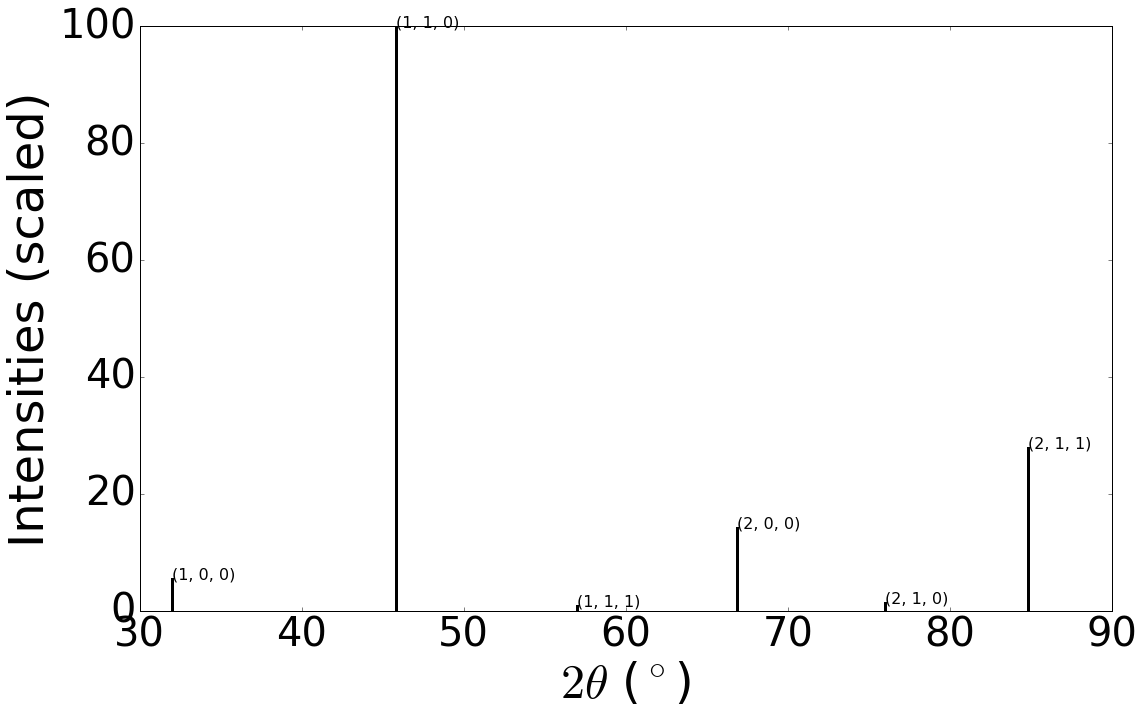

In [80]:
%matplotlib inline
xrdc.show_xrd_plot(nacl)

### Exercise: Plot the XRD spectra, Bandstructure, and electronic DOS of Au

In [ ]:
from pymatgen.analysis.diffraction.xrd import XRDCalculator
from pymatgen.electronic_structure.plotter import BSPlotter, DosPlotter
from pymatgen.electronic_structure.core import OrbitalType

data = mpr.get_data('TiO2')
structures = mpr.get_structures("TiO2")
xrd_calc = XRDCalculator()
#xrd_calc.show_xrd_plot(structures[0])

bs = mpr.get_bandstructure_by_material_id(data[0]["material_id"])
print(bs.get_band_gap())
plotter=BSPlotter(bs)
#plotter.get_plot().show()
#plotter.plot_brillouin()

dos = mpr.get_dos_by_material_id(data[0]["material_id"])
dp = DosPlotter()
dos_ti = dos.get_element_spd_dos("Ti")
dos_o = dos.get_element_spd_dos("O")
dp.add_dos("O p-states", dos_o[OrbitalType.p])
dp.add_dos("Ti d-states", dos_ti[OrbitalType.d])
dp.get_plot().show()

## Phase diagrams

### Exercise: Plot phase diagrams for the Ba-Ni-O chemical system

In [ ]:
from pymatgen.phasediagram.maker import PhaseDiagram
from pymatgen.phasediagram.plotter import PDPlotter

entries = mpr.get_entries_in_chemsys(["Ba", "Ni", "O"])
pd = PhaseDiagram(entries)
plotter = PDPlotter(pd, show_unstable=True) # show_unstable=true
plotter.show()

## Tensors

### Fit a "noisy" tensor to a particular crystal structure

## Surfaces

### Generate all of the low-index facets for BCC Fe

In [ ]:
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
from pymatgen.core.surface import generate_all_slabs
lattice = mg.Lattice.cubic(2.85)
structure = mg.Structure(lattice, ["Fe", "Fe"],
                         [[0, 0, 0], [0.5, 0.5, 0.5]])

slabs = generate_all_slabs(structure, 1, 4, 10)
first_slab = slabs[0]
first_slab.miller_index
for slab in slabs:
    print slab.miller_index

## Etc.

In [ ]:
data = mpr.get_data("mp-149")
et = data[0]["elasticity"]["elastic_tensor"]
structure = Structure.from_str(data[0]["cif"], fmt="cif")